In [13]:
# generate 2 2D clouds of points
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel


points_num = 1000

# Generate two cloud clusters of points
np.random.seed(42)
cloud_1 = np.random.normal(loc=0, scale=1, size=(points_num // 2, 2))
cloud_2 = np.random.normal(loc=5, scale=1, size=(points_num // 2, 2))


labeled_points_num = 20
# randomly sample points from each cloud
sampled_indexes_1 = np.random.choice(cloud_1.shape[0], labeled_points_num // 2, replace=False)
sampled_indexes_2 = np.random.choice(cloud_2.shape[0], labeled_points_num // 2, replace=False)

# Create labeled dataset
X_labeled = np.vstack((cloud_1[sampled_indexes_1], cloud_2[sampled_indexes_2]))
Y_labeled = np.hstack((np.zeros(labeled_points_num // 2), np.ones(labeled_points_num // 2)))  # 0 for cloud_1, 1 for cloud_2

# Create unlabeled dataset
mask_1 = np.ones(points_num // 2, dtype=bool)
mask_1[sampled_indexes_1] = False

mask_2 = np.ones(points_num // 2, dtype=bool)
mask_2[sampled_indexes_2] = False

X_unlabeled = np.vstack((cloud_1[mask_1], cloud_2[mask_2]))
Y_unlabeled = np.hstack((np.zeros((points_num - labeled_points_num) // 2), np.ones((points_num - labeled_points_num) // 2)))

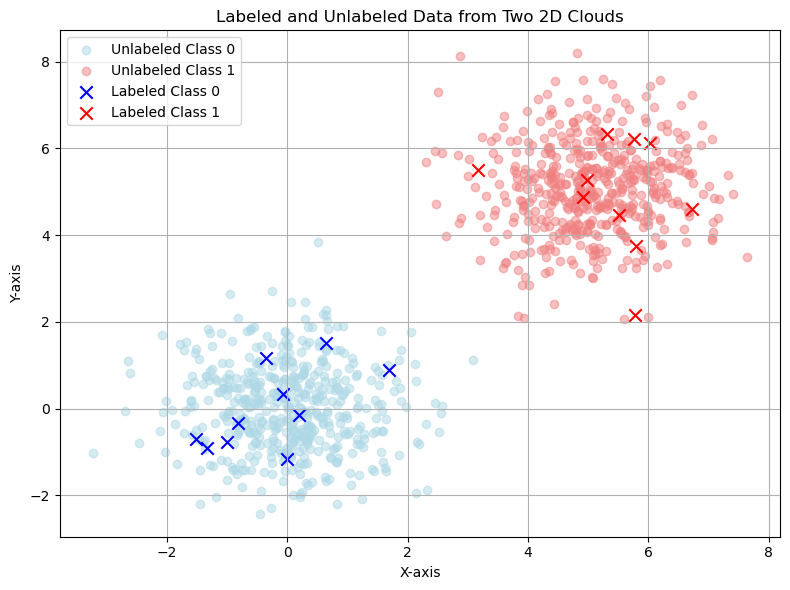

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Unlabeled data
plt.scatter(
    X_unlabeled[Y_unlabeled == 0][:, 0], 
    X_unlabeled[Y_unlabeled == 0][:, 1], 
    c='lightblue', label='Unlabeled Class 0', alpha=0.5
)
plt.scatter(
    X_unlabeled[Y_unlabeled == 1][:, 0], 
    X_unlabeled[Y_unlabeled == 1][:, 1], 
    c='lightcoral', label='Unlabeled Class 1', alpha=0.5
)

# Labeled data
plt.scatter(
    X_labeled[Y_labeled == 0][:, 0], 
    X_labeled[Y_labeled == 0][:, 1], 
    c='blue', marker='x', label='Labeled Class 0', s=80
)
plt.scatter(
    X_labeled[Y_labeled == 1][:, 0], 
    X_labeled[Y_labeled == 1][:, 1], 
    c='red', marker='x', label='Labeled Class 1', s=80
)

plt.legend()
plt.title("Labeled and Unlabeled Data from Two 2D Clouds")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
%reload_ext autoreload
%autoreload 2

from solvers_digits import GradientDescentSolver, BCGDSolver, CoordinateMinimizationSolver
from sklearn.metrics import accuracy_score

solver = BCGDSolver(X_labeled, Y_labeled, X_unlabeled, cache=True, lr=0.01)


max_iters = 2000
for _ in range(max_iters):
    solver.step()

y_pred = (solver.y_unlabeled > 0.5)
accuracy_score(Y_unlabeled, y_pred)


0.9989795918367347

Step size (1/L): 0.001997
Step size (2/(L+σ)): 0.003993


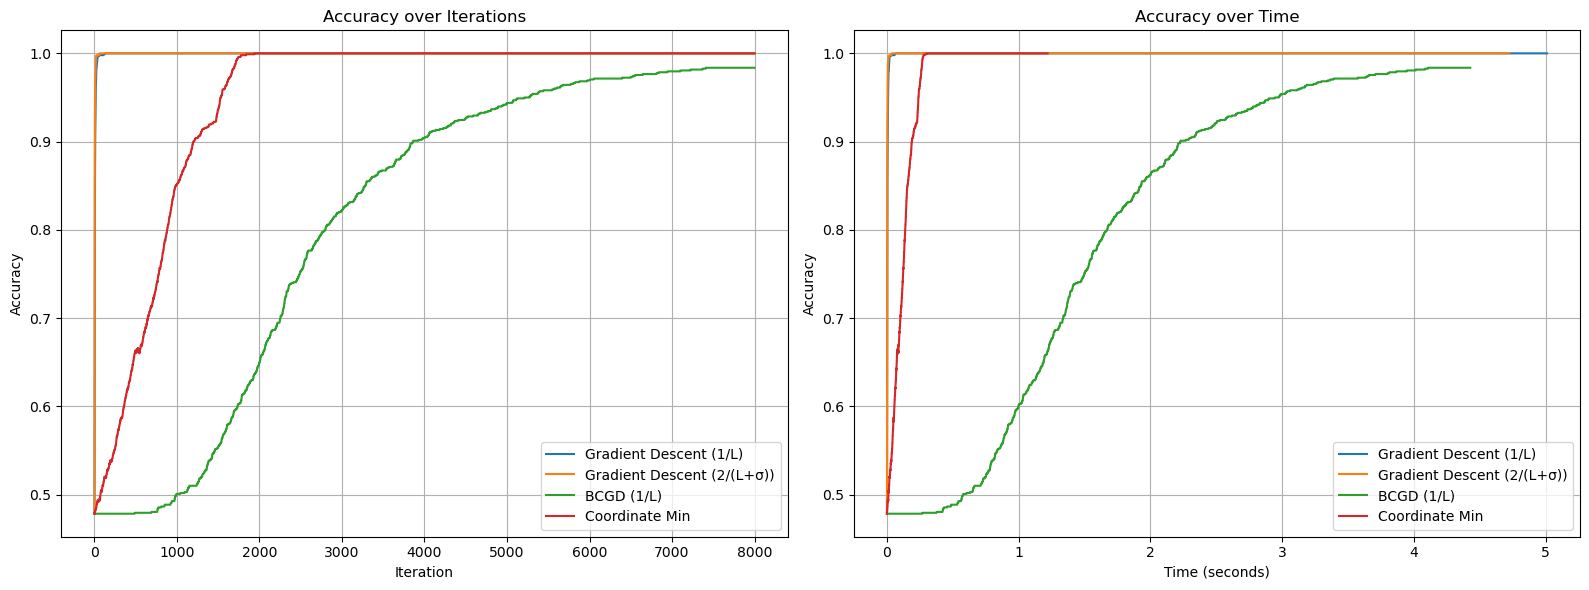

In [17]:
%reload_ext autoreload
%autoreload 2
import random
import time
from sklearn.metrics import accuracy_score
from solvers_digits import GradientDescentSolver, BCGDSolver, CoordinateMinimizationSolver


random.seed(42)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

def compute_lipschitz_constants(W_uu):
    D = np.diag(W_uu.sum(axis=1))
    L_u = D - W_uu
    H = 2 * L_u
    eigvals = np.linalg.eigvalsh(H)
    L = eigvals.max()
    sigma = max(eigvals.min(), 1e-8)  # Prevent division by zero
    return L, sigma

gamma = 1 / 2

max_iters = 8000
y_init = np.random.rand(X_unlabeled.shape[0]) # random initialization of starting point for each solver
# Compute W_uu just for estimating step sizes
W_uu_for_eta = rbf_kernel(X_unlabeled, X_unlabeled, gamma=gamma)
L, sigma = compute_lipschitz_constants(W_uu_for_eta)
eta_1 = 1 / L
eta_2 = 2 / (L + sigma)

print(f"Step size (1/L): {eta_1:.6f}")
print(f"Step size (2/(L+σ)): {eta_2:.6f}")

# Initialize solvers with the same data and label guesses
# Each solver receives a fresh copy of the initial soft labels
solvers = {
    "Gradient Descent (1/L)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_1),
    "Gradient Descent (2/(L+σ))": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_2),
    "BCGD (1/L)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=False, lr=eta_1), #0.005
    "Coordinate Min": CoordinateMinimizationSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy())
}


for name, solver in solvers.items():
    accuracy_list = []
    time_list = []
    start_time = time.time()
    for _ in range(max_iters):
        y_pred = (solver.y_unlabeled > 0.5)
        accuracy = accuracy_score(Y_unlabeled, y_pred)
        accuracy_list.append(accuracy)
        solver.step()
        time_list.append(time.time() - start_time)

    ax1.plot(accuracy_list, label=name)
    ax2.plot(time_list, accuracy_list, label=name)

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy over Iterations')
ax1.legend()
ax1.grid()

ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Time')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

Step size (1/L): 0.001997
Step size (2/(L+σ)): 0.003993


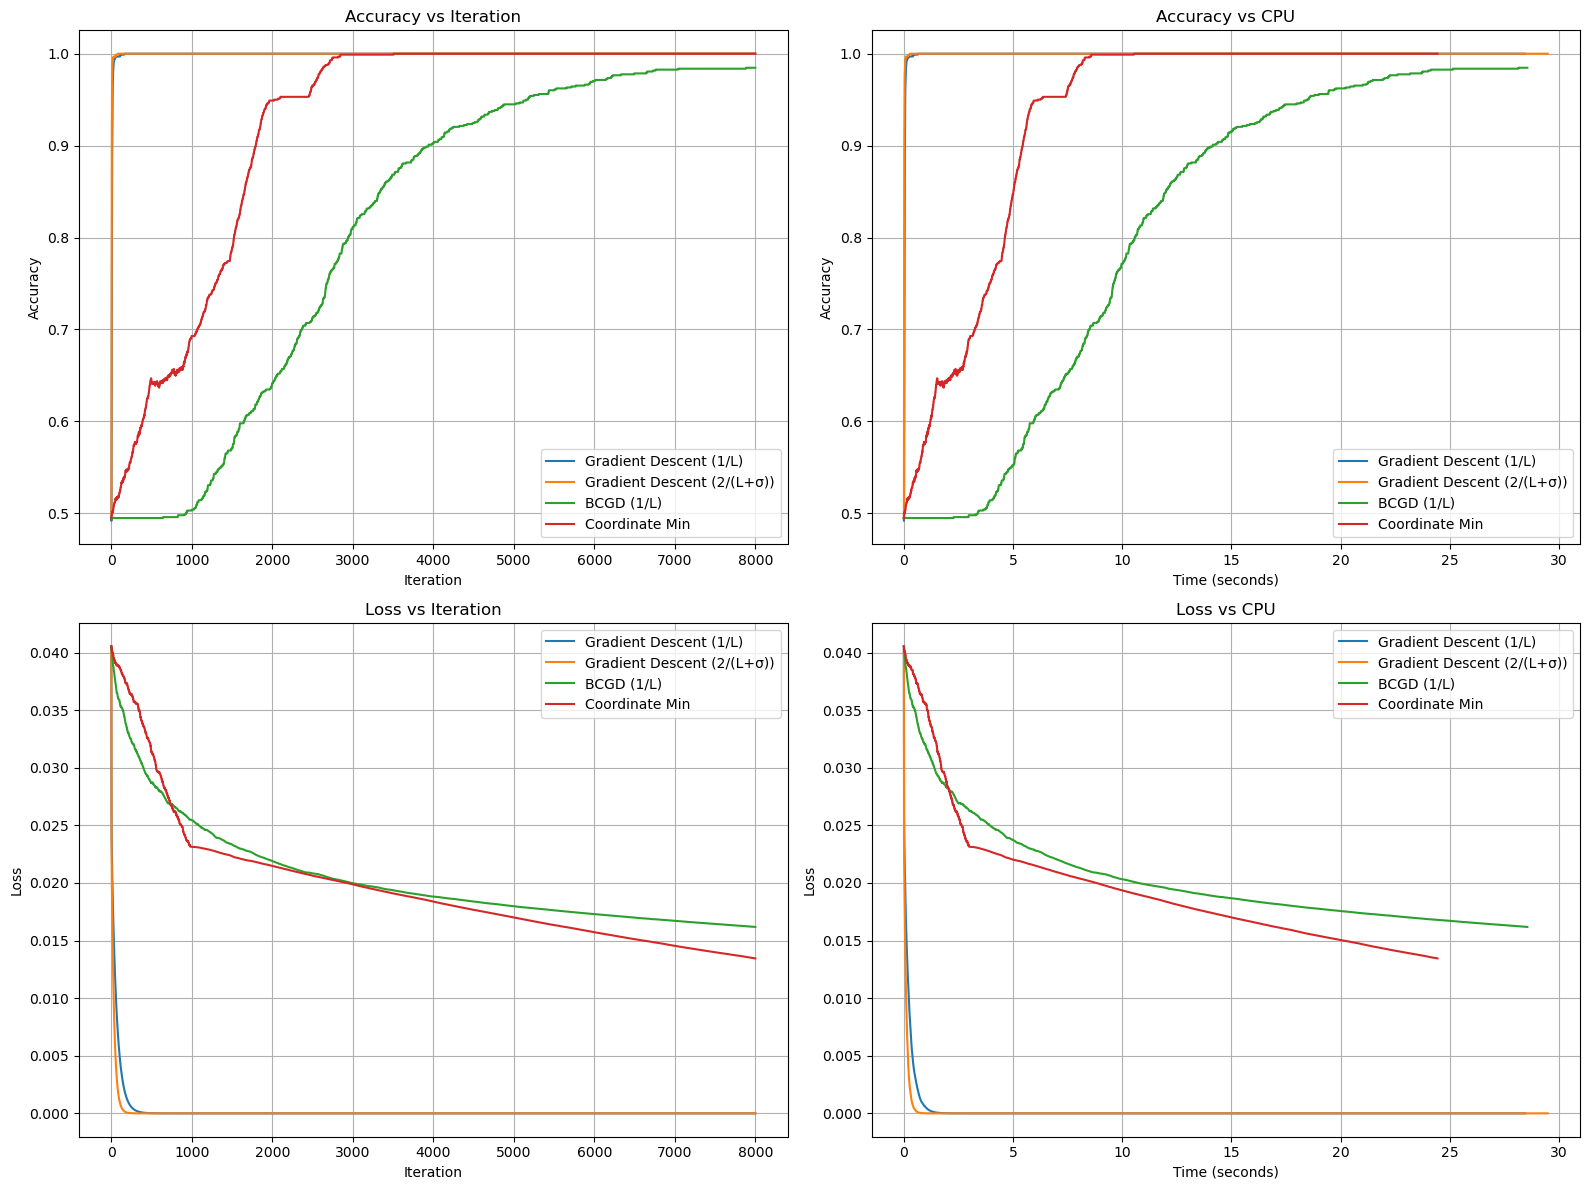

                       Solver  Accuracy  Precision    Recall        F1
0      Gradient Descent (1/L)  1.000000   1.000000  1.000000  1.000000
1  Gradient Descent (2/(L+σ))  1.000000   1.000000  1.000000  1.000000
2                  BCGD (1/L)  0.984694   0.989691  0.979592  0.984615
3              Coordinate Min  1.000000   1.000000  1.000000  1.000000


In [18]:
"""Here we have to implement if wished the loss function for plotting, therefore we need to add the calculation in the solver classes."""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import time


max_iters = 8000
y_init = np.random.rand(X_unlabeled.shape[0])

def compute_lipschitz_constants(W_uu):
    D = np.diag(W_uu.sum(axis=1))
    L_u = D - W_uu
    H = 2 * L_u
    eigvals = np.linalg.eigvalsh(H)
    L = eigvals.max()
    sigma = max(eigvals.min(), 1e-8)  # Prevent division by zero
    return L, sigma

gamma = 1 / 2

max_iters = 8000
y_init = np.random.rand(X_unlabeled.shape[0]) # random initialization of starting point for each solver
# Compute W_uu just for estimating step sizes
W_uu_for_eta = rbf_kernel(X_unlabeled, X_unlabeled, gamma=gamma)
L, sigma = compute_lipschitz_constants(W_uu_for_eta)
eta_1 = 1 / L
eta_2 = 2 / (L + sigma)

print(f"Step size (1/L): {eta_1:.6f}")
print(f"Step size (2/(L+σ)): {eta_2:.6f}")

# Initialize solvers with the same data and label guesses
# Each solver receives a fresh copy of the initial soft labels
solvers = {
    "Gradient Descent (1/L)": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_1),
    "Gradient Descent (2/(L+σ))": GradientDescentSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), lr=eta_2),
    "BCGD (1/L)": BCGDSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy(), cache=False, lr=eta_1), #0.005
    "Coordinate Min": CoordinateMinimizationSolver(X_labeled, Y_labeled, X_unlabeled, y_init.copy())
}



# Create figure for plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

for name, solver in solvers.items():
    accuracy_list = []
    loss_list = []
    time_list = []
    start_time = time.time()
    
    for i in range(max_iters):
        # Get predictions and calculate metrics
        y_pred = (solver.y_unlabeled > 0.5).astype(int)
        
        # Handles cases where there are no positive predictions
        if np.sum(y_pred) == 0:
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = precision_score(Y_unlabeled, y_pred, zero_division=0)
            recall = recall_score(Y_unlabeled, y_pred)
            f1 = f1_score(Y_unlabeled, y_pred)
        
        accuracy = accuracy_score(Y_unlabeled, y_pred)
        loss = solver.compute_loss()
        elapsed = time.time() - start_time
        
        accuracy_list.append(accuracy)   
        loss_list.append(loss)
        time_list.append(elapsed)
        
        solver.step()
    
    # Plot accuracy
    ax1.plot(accuracy_list, label=name)
    ax2.plot(time_list, accuracy_list, label=name)
    
    # Plot loss
    ax3.plot(loss_list, label=name)
    ax4.plot(time_list, loss_list, label=name)

# Configure plots
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Iteration')
ax1.legend()
ax1.grid()

ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs CPU')
ax2.legend()
ax2.grid()

ax3.set_xlabel('Iteration')
ax3.set_ylabel('Loss')
ax3.set_title('Loss vs Iteration')
ax3.legend()
ax3.grid()

ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('Loss')
ax4.set_title('Loss vs CPU')
ax4.legend()
ax4.grid()

plt.tight_layout()
plt.show()

# Print final metrics
final_metrics = []
for name, solver in solvers.items():
    y_pred = (solver.y_unlabeled > 0.5).astype(int)
    final_metrics.append({
        'Solver': name,
        'Accuracy': accuracy_score(Y_unlabeled, y_pred),
        'Precision': precision_score(Y_unlabeled, y_pred, zero_division=0),
        'Recall': recall_score(Y_unlabeled, y_pred),
        'F1': f1_score(Y_unlabeled, y_pred)
    })

print(pd.DataFrame(final_metrics))